In [14]:
import torch
import torch.nn as nn

In [22]:
def initialWeights(model):
    for m in model.modules():
        if isinstance(m ,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)


In [27]:
class Generator(nn.Module):
    def __init__(self,z_dim,img_channels,features_g):
        super(Generator,self).__init__()
        self.net=nn.Sequential(
            self._block(z_dim,features_g*16,4,1,0),
            self._block(features_g*16,features_g*8,4,2,1),
            self._block(features_g*8,features_g*4,4,2,1),
            self._block(features_g*4,features_g*2,4,2,1),
            nn.ConvTranspose2d(features_g*2,img_channels,4,2,1),
            nn.Tanh()

        )
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self,x):
        return self.net(x)

In [24]:
class Discriminator(nn.Module):
    def __init__(self,img_channels,features_d):
        super().__init__()
        self.disc=nn.Sequential(
            nn.Conv2d(img_channels,features_d,kernel_size=4,stride=2,padding=1),
            self._block(features_d,features_d*2,4,2,1),
            self._block(features_d*2,features_d*4,4,2,1),
            self._block(features_d*4,features_d*8,4,2,1),
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),
            nn.Sigmoid()
        )
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.02)
        )
    
    def forward(self,x):
        return self.disc(x)

In [29]:
def test():
    N,in_channels,H,W=8,3,64,64
    z_dim=100
    x=torch.randn((N,in_channels,H,W))
    disc=Discriminator(in_channels,8)
    initialWeights(disc)
    assert disc(x).shape==(N,1,1,1)

    gen=Generator(z_dim,in_channels,8)
    initialWeights(gen)
    z=torch.randn((N,z_dim,1,1))
    assert gen(z).shape== (N,in_channels, H, W)
    
test()


In [33]:
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

# Hyperparameters

device="cuda" if torch.cuda.is_available() else "cpu"
lr=2e-4
batch_size=128
img_size=64
in_channels=1
z_dim=100
num_epochs=5
features_d=64
features_g=64

transforms=transforms.Compose(
    [   
        transforms.Resize(img_size),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,),(0.5,)) #for single channel it works fine
        transforms.Normalize(
            [0.5 for _ in range(in_channels)],[0.5 for _ in range(in_channels)]
        ),
    ]
)

dataset=datasets.MNIST(root='./data',train=True,transform=transforms,download=True)
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)

/Users/shreygarg/Desktop/MLPytorch/myenv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


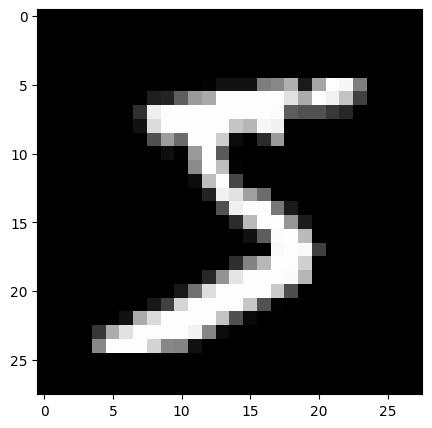

In [38]:
import matplotlib.pyplot as plt
res=dataset.train_data[0]
plt.figure(figsize=(5,5))
plt.imshow(res,cmap="grey")
plt.show()

In [43]:
it=iter(dataloader)
first=next(it)
img,target=first
img.shape


torch.Size([128, 1, 64, 64])

In [48]:
# from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
disc=Discriminator(in_channels,features_d).to(device)
initialWeights(disc)
gen=Generator(z_dim,in_channels,features_g).to(device)
initialWeights(gen)
optim_disc=optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))
optim_gen=optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))

fixedNoise=torch.randn((batch_size,z_dim,1,1)).to(device)

criterion=nn.BCELoss()
# real_writer=SummaryWriter('/logs/real')
# fake_writer=SummaryWriter('/logs/fake')
# step=0



In [ ]:
for epochs in range(num_epochs):
    for batch_idx,(real,target) in enumerate(dataloader):

        real=real.to(device)
        noise=torch.randn(batch_size,z_dim,1,1).to(device)
        fake=gen(noise)

        disc_real=disc(real).reshape(-1)
        disc_real_loss=criterion(disc_real,torch.ones_like(disc_real))
        disc_fake=disc(fake).reshape(-1)
        
        disc_fake_loss=criterion(disc_fake,torch.zeros_like(disc_fake))
        
        lossD=(disc_fake_loss+disc_real_loss)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        # lossD.backward()
        optim_disc.step()


        output=disc(fake).reshape(-1)
        lossG=criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()


        if batch_idx == 0:
            print(f'Epochs : {epochs}/{num_epochs} | Batch: {batch_idx}/{batch_size} | loss: {lossG:.4f}') 

/Users/shreygarg/Desktop/MLPytorch/myenv/lib/python3.9/site-packages/torch/autograd/graph.py:825: UserWarning: Error detected in ConvolutionBackward0. Traceback of forward call that caused the error:
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/shreygarg/Desktop/MLPytorch/myenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/shreygarg/Desktop/MLPytorch/myenv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/shreygarg/Desktop/MLPytorch/myenv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
  

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 1, 4, 4]] is at version 6; expected version 5 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!